In [1]:
import numpy as np
import pandas as pd
import os, sys, gc, time, warnings, pickle, psutil, random

import time

warnings.filterwarnings('ignore')

In [2]:
from razor.api import project_space_path
import razor
import razor.flow as rf
import typing as t
import logging
import pandas as pd
from razor.api import project_space_path


# Original Lag Code

In [3]:
@rf.block(executor=rf.ContainerExecutor(cores=2, memory=20000))
class LagCreator:
    grid_path: t.Any
        
    def run(self):
        ########################### Apply on grid_df

        grid_df = pd.read_pickle(project_space_path(self.grid_path))

        TARGET = 'sales'         # Our main target
        END_TRAIN = 1913         # Last day in train set
        MAIN_INDEX = ['id','d']  # We can identify item by these columns
        
        # We need only 'id','d','sales'
        # to make lags and rollings
        grid_df = grid_df[['id','d','sales']]
        SHIFT_DAY = 28

        # Lags
        # with 28 day shift
        start_time = time.time()
        self.logger.info('Create lags')

        LAG_DAYS = [col for col in range(SHIFT_DAY,SHIFT_DAY+15)]
        grid_df = grid_df.assign(**{
                '{}_lag_{}'.format(col, l): grid_df.groupby(['id'])[col].transform(lambda x: x.shift(l))
                for l in LAG_DAYS
                for col in [TARGET]
            })

        # Minify lag columns
        for col in list(grid_df):
            if 'lag' in col:
                grid_df[col] = grid_df[col].astype(np.float16)

        self.logger.info('%0.2f min: Lags' % ((time.time() - start_time) / 60))

        # Rollings
        # with 28 day shift
        start_time = time.time()
        self.logger.info('Create rolling aggs')

        for i in [7,14,30,60,180]:
            self.logger.info(f'Rolling period: {i}')
            grid_df['rolling_mean_'+str(i)] = grid_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(SHIFT_DAY).rolling(i).mean()).astype(np.float16)
            grid_df['rolling_std_'+str(i)]  = grid_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(SHIFT_DAY).rolling(i).std()).astype(np.float16)

        # Rollings
        # with sliding shift
        for d_shift in [1,7,14]: 
            self.logger.info(f'Shifting period: {d_shift}')
            for d_window in [7,14,30,60]:
                col_name = 'rolling_mean_tmp_'+str(d_shift)+'_'+str(d_window)
                grid_df[col_name] = grid_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(d_shift).rolling(d_window).mean()).astype(np.float16)


        self.logger.info('%0.2f min: Lags' % ((time.time() - start_time) / 60))

        self.logger.info(f'Save lags and rollings  {grid_df.shape}')
        grid_df.to_pickle(project_space_path(f'M5Forecasting/lags_df_{str(SHIFT_DAY)}.pkl'))


In [4]:
lag_creator = LagCreator(grid_path = 'M5Forecasting/m5-simple-fe/grid_part_1.pkl')


In [5]:
p = rf.Pipeline("lag_creator", targets=[lag_creator])  #preprocess


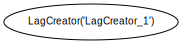

In [6]:
p.show()

In [7]:
deployed_pipeline = razor.api.engines('DS-engine').execute(pipeline=p)


In [8]:
deployed_pipeline

PlatformPipelineRun(project_id='c0b26d85-a4c9-44f5-9d0e-f540dd2de644', pipeline_id='947bee16-03c8-11eb-9c1c-0242ac110009', pipeline_name='lag_creator', pipeline_run_id='69eaef81-dad9-43aa-ae18-840a86d10dac', pipeline_version=None, comment=None, created_on='2020-10-01T09:29:32.565+00:00', start_time=None, end_time=None, eta=0, run_at=1601544572565, run_duration=0, compute_time=0, wait_time=-46, ran_by_user=RanByUser(user_name='souryadipta das', email='souryadipta.das@razorthink.com'), status='IN_PROGRESS', block_status=[PlatformPipelineBlockRun(pipeline_run_id='69eaef81-dad9-43aa-ae18-840a86d10dac', pipeline_name='lag_creator', pipeline_status='IN_PROGRESS', block_id='674a1773-c144-4b01-908b-26b9b4b433c4', block_run_id='7e75788f-fa11-4b78-9edf-441235e2b1b3', block_name='LagCreator_1', resource_spec=ResourceAllocated(cores=2, memory=20000, use_gpu=False, gpu=0, use_gpu_if_available=False, cluster_configuration={'worker': None, 'workerCore': None, 'workerMemory': None, 'numberOfInstances': None, 'maxServerCount': None}, additional_env={}, run_env='PYTHON'), technology='PYTHON', status='READY_TO_GO', containers=[], cluster_id='674a1773-c144-4b01-908b-26b9b4b433c4', _log=None, _metric=None, wait_time=0, compute_time=0, start_time=None, end_time=None, queued_at='2020-10-01T09:29:33.000+00:00')], run_number=204, pipeline_variable_list=[], block_run_details=[BlockRunDetail(block_id='674a1773-c144-4b01-908b-26b9b4b433c4', block_run_id='7e75788f-fa11-4b78-9edf-441235e2b1b3', block_name='LagCreator_1', technology='PYTHON', log_path=None, input_parameters='{\n  "grid_path": {\n    "dtype": "Any",\n    "required": "false",\n    "series": false,\n    "adapter": "eJxrYJmqxgABPYJFiVX5RXppOfnlern5Kak5xVN6ePLy8wviE1MSC0pSi6ZMnqIHAF/+ELQ=",\n    "validator": "eJxrYJmqwQABPYJFiVX5RXppOfnlern5Kak5xVN6+PLy8wviyxJzMlMSS/KLpkyeogcAg2wRnQ==",\n    "source_id": null,\n    "source_name": null,\n    "inferred_type": "STATIC",\n    "value": "eJxrYJmqxwABPVq+pm75RanJicUlmXnp+rmmusWZuQU5qbppqfrpRZkp8QWJRSXxhnoF2TlT9ADQohIn"\n  }\n}', output_parameters=None, status='READY_TO_GO', created_at='2020-10-01T09:29:32.656+00:00', queued_at='2020-10-01T09:29:33.000+00:00', start_time=None, end_time=None, compute_time=0, wait_time=0, run_time=0, block_run_output_list=[], resource_allocated=ResourceAllocated(cores=2, memory=20000, use_gpu=False, gpu=0, use_gpu_if_available=False, cluster_configuration={'worker': None, 'workerCore': None, 'workerMemory': None, 'numberOfInstances': None, 'maxServerCount': None}, additional_env={}, run_env='PYTHON'))], pipeline_json='{\n  "id": "947bee16-03c8-11eb-9c1c-0242ac110009",\n  "projectId": "c0b26d85-a4c9-44f5-9d0e-f540dd2de644",\n  "name": "lag_creator",\n  "description": "",\n  "blocks": [\n    {\n      "name": "LagCreator_1",\n      "id": "674a1773-c144-4b01-908b-26b9b4b433c4",\n      "artifact_id": null,\n      "class_name": "LagCreator",\n      "code": "eJyVV1tvG8cV3lkuKUq2dbOri+O6RHoBXVuUbMuy7AhGHcpJbFpsIAlwDFQYLDlLzkrLXWovstRQQVLZFgUMjBbevtQIKgHtc4vGLYqigNPX/Ii+py/9Cek3u0tRTuw2lQBy98zMmXO+c/v4sfbrtQEl+hOjVcsJWNOsrllG4chzKMapa/At5uq+Qb01wzJ8x6ZVS/e88GmY54o4RRv62qvWRLYSmJZv2l4oNH+raUAo+u7q9aJr6L7jhlzNcy3Pe3iWp0XGqawaVR97HoXboeihlDlVSsOyJ3KsNnOZzU5NXdZrU9OzxlSlOnV5euoqu3KpdunqpRk9LPvhIk7lRR+lDYcFloGTIosX3bTl4wClum07vu6bju1Bgit6667JaFP3eSgysM+066FI3bS3YIMnUm5gh3Cvn9ZMy6K1wK7Ks4nTA12noyWIIT1BE49px91s0WHGsnx5BAvzJVJSSj34T739A1VRfGWf+GpLWU3tkAOypzGyR5i6TViKaXV1W21r8omRempcwWp6T/G1fe1A2U7hTHo/wzIHhCish2UfKn5PW2krrHdU2VHnlR2yrbW11WxN2SW7Wk1lfezYw2xLkytPcNPmBb+3re2QeWUlt51mx1vptYz7sK210uPKfp9/bPX4AZFvc8r6w3tKctuJ+PZWakxh/W8oI4q8/WsWDUjZ5mM2CM0f7aUT6VA7/Uz5VJVrbW3/BEvV4W+b4K7+XWU3DfuG2cmH2QPSvZud8gfa6R0yqsy97sx3vnFmpHtm/Z/3lE2fjcIOa09N7Bhrqx07NhfZONbu7KXYaZxS5Sn2xqiC55R83s5841Z1N4Vbz3z91lZmTvklWf/FPflZ++9oJWvfRWwGjyAy5KvsLG5GdJ4p7HufRvmAyCpLSpgvi7SnW4YXLmz1CNVkoSAsLJ0Rx6I6MnKWXvdC/v04udRSqrRUHKzjppXsNmmRX6nrGrScOyfUwhTyu+pY4eNQnJ0zm1s+d+wJ024G/sTlianaFX3WmLl42Zip3EChzlmm51edRvNGWBorqhmpQ5aZeLNbwgUUSWHOcqq65d0oHD0x0DUoWzpZ/IkpDZrdU9q